In [1]:
import tensorflow as tf
from keras.datasets import mnist
from keras import layers
from keras import Model
import keras.backend as K
import numpy as np

In [2]:
def multi_binary_mlp(hidden_sizes, n_out, activation="leaky_relu"):
    input_tensor = layers.Input(shape=(28*28,))
    z = input_tensor
    for size in hidden_sizes:
        z = layers.Dense(size, activation=activation)(z)
    z = layers.Dense(n_out, activation="tanh")(z)
    model = Model(input_tensor, z)
    return model


# Custom loss function
# minimize the magnitude of the covariance over the predictions
def multiclass_loss(cov_weight=1, center_weight=1, mag_weight=1):
    def loss(y_true, y_pred):
        # Calculate the covariance matrix
        # https://stackoverflow.com/questions/47709854/how-to-get-covariance-matrix-in-tensorflow
        x = y_pred
        mean_x = K.mean(x, axis=0, keepdims=True)
        mx = K.transpose(mean_x) @ mean_x
        vx = (K.transpose(x) @ x)/K.cast(K.shape(x)[0], dtype="float32")
        cov_xx = vx - mx
        # set the diagonal to zero
        cov_xx = tf.linalg.set_diag(cov_xx, tf.zeros_like(tf.linalg.diag_part(cov_xx)))

        cov_loss = K.mean(K.abs(cov_xx)) # Optimal at 0

        # Calculate the magnitude of the average prediction
        center_loss = K.abs(mean_x) # Optimal at 0

        # Calculate the average magnitude of the predictions
        mag_loss = K.mean(K.abs(x)) # Optimal at 1

        # Calculate the loss
        return cov_weight*cov_loss + center_weight*center_loss - mag_weight*mag_loss + mag_weight
        
    return loss


class Classifier:

    def __init__(self, X, y, hidden_sizes, n_out, activation="relu", n_classes=10, cov_weight=1, center_weight=1, mag_weight=1, seed=None):
        self.model = multi_binary_mlp(hidden_sizes=hidden_sizes, n_out=n_out, activation=activation)
        loss_fn = multiclass_loss(cov_weight=cov_weight, center_weight=center_weight, mag_weight=mag_weight)
        self.model.compile(optimizer="adam", loss=loss_fn)

        self.n_out = n_out
        self.X = X
        self.y = y

        self.buckets = None
        self.n_classes = n_classes
    
    
    def train_nn(self, epochs=10, batch_size=128):
        self.model.fit(self.X, self.y, epochs=epochs, batch_size=batch_size)

    def get_outputs(self, X):
        return self.model.predict(X) # (batch_size, n_out)

    def outputs_to_index(self, outputs):
        bin_outputs = (outputs > 0).astype(int) # (batch_size, n_out)

        # interpret bin_outputs as a batch of binary numbers
        # convert each binary number to a decimal number
        two_powers = 2**np.arange(outputs.shape[1]) # (1, n_out)
        indecies = bin_outputs.dot(two_powers) # (batch_size,)
        return indecies


    def train_buckets(self):
        outputs = self.get_outputs(self.X) # (batch_size, n_out)
        indecies = self.outputs_to_index(outputs)
        n_buckets = 2**self.n_out
        self.buckets = np.zeros((n_buckets, self.n_classes)) # (n_buckets, n_classes)
        for i, index in enumerate(indecies):
            self.buckets[index, self.y[i]] += 1
        
        # normalize each row
        self.buckets = self.buckets / (self.buckets.sum(axis=1, keepdims=True) + 1e-8)


    def predict(self, X):
        if self.buckets is None:
            # raise an error
            raise Exception("You must train the buckets before you can predict: classifier.train_buckets()")
        
        outputs = self.get_outputs(X) # (batch_size, n_out)
        indecies = self.outputs_to_index(outputs)
        return self.buckets[indecies]
    

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        y_pred = y_pred.argmax(axis=1)
        return np.mean(y_pred == y)

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# flatten 28x28 images to a 784 vector for each image
x_train = x_train.reshape((60000, 28*28))
x_test = x_test.reshape((10000, 28*28))

# normalize inputs from 0-255 to 0-1
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


In [7]:
n_out = 4
classifier = Classifier(
    x_train,
    y_train,
    hidden_sizes=[128, 64],
    n_out=n_out,
    cov_weight=0.2,
    center_weight=1,
    mag_weight=0.2,
)
classifier.train_buckets()
starting_buckets = classifier.buckets.copy()
print("Untrained Accuracy:", classifier.evaluate(x_test, y_test))
classifier.train_nn(epochs=10)
classifier.train_buckets()
ending_buckets = classifier.buckets.copy()
print("Trained Accuracy:", classifier.evaluate(x_test, y_test))


Untrained Accuracy: 0.2239
Epoch 1/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1668
Epoch 2/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1062
Epoch 3/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0960
Epoch 4/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0942
Epoch 5/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0916
Epoch 6/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0904
Epoch 7/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0915
Epoch 8/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0874
Epoch 9/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0924
Epoch 10/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0895
Trained Accuracy: 0.511


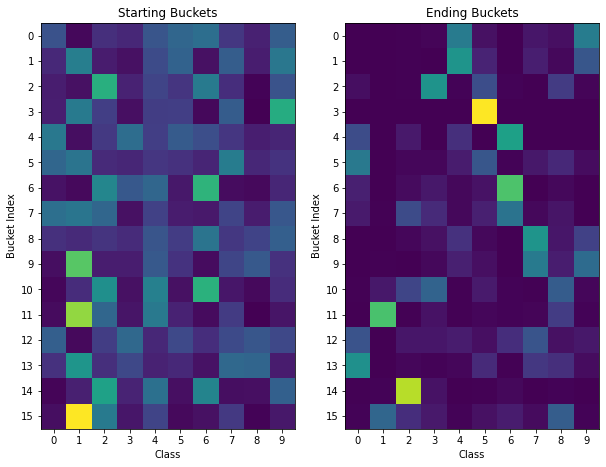

In [8]:
# Show the difference between the starting and ending buckets
import matplotlib.pyplot as plt
# plot the two images next to each other with the same colorbar
fig, ax = plt.subplots(1, 2, figsize=(10, n_out*2))
ax[0].imshow(starting_buckets)
ax[1].imshow(ending_buckets)
# label the axes
ax[0].set_xlabel("Class")
ax[1].set_xlabel("Class")
ax[0].set_ylabel("Bucket Index")
ax[1].set_ylabel("Bucket Index")

# Title the images
ax[0].set_title("Starting Buckets")
ax[1].set_title("Ending Buckets")

# set tick space to be every number
ax[0].set_xticks(np.arange(10))
ax[1].set_xticks(np.arange(10))
ax[0].set_yticks(np.arange(2**n_out))
ax[1].set_yticks(np.arange(2**n_out))

plt.show()



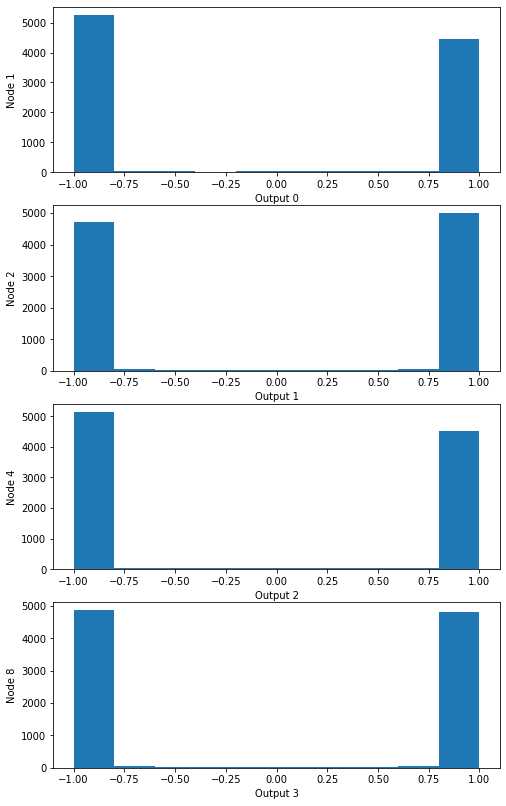

In [9]:
outputs = classifier.get_outputs(x_test)
# for each output plot a histogram of the values
fig, ax = plt.subplots(n_out, 1, figsize=(8, 14))
for i in range(n_out):
    ax[i].hist(outputs[:, i])
    ax[i].set_xlabel("Output {}".format(i))
    ax[i].set_ylabel("Node %d" % 2**i)
    # remove ticks
    # ax[i].set_yticks([])
    # ax[i].set_xticks([-1, 1])
plt.show()
